<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

Import libraries

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_sample_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [11]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1-9Tp6ZMZG9zKieBTO_Sd6W-HdzXPy5OL'
file_name = 'selected_features_500.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_df = pd.read_csv(file_name)
selected_features_df.shape

(58976, 501)

In [12]:
selected_features_df.head()

,Lumb/lmbsac fus ant/post,Insert intestinal tube,"Urine Casts, Other",Open sigmoidectomy NEC,CANDIDA PARAPSILOSIS,DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI,CANDIDA (TORULOPSIS) GLABRATA,Laparotomy NEC,Lumb/lmbosac fus ant/ant,Bronch/trach lavage NEC,CA-125,RELIGION_7TH DAY ADVENTIST,ACINETOBACTER BAUMANNII,DIAGNOSIS_AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA,"Hematocrit, Other Fluid",ETHNICITY_ASIAN - CHINESE,Injct/inf immunoglobulin,DIAGNOSIS_SUBDURAL HEMORRHAGE,Pericardiotomy,"Hematocrit, Pleural",Other gastrostomy,Absolute CD8 Count,ENTEROBACTER CLOACAE COMPLEX,DIAGNOSIS_CELLULITIS,RELIGION_BUDDHIST,DIAGNOSIS_INTRAPARENCHYMAL HEMORRHAGE,Muscle or fascia graft,Opn lft hemicolectmy NEC,Opn fx red w int fix NEC,Small bowel suture NEC,DIAGNOSIS_MYOCARDIAL INFARCTION,Perc ins carotid stent,Therapeu plasmapheresis,Open liver biopsy,Annuloplasty,Pacemaker rate check,Absolute CD3 Count,Immobiliz/wound attn NEC,DIAGNOSIS_UPPER GASTROINTESTINAL BLEED,PRESUMPTIVE GARDNERELLA VAGINALIS,Opn/oth rep mitral valve,Blasts,DIAGNOSIS_UNSTABLE ANGINA,VIRIDANS STREPTOCOCCI,Contrast arteriogram NEC,ETHNICITY_WHITE - RUSSIAN,Temporary ileostomy,Mesothelial cells,Repl stent in bile duct,Other tracheal repair,ALPHA STREPTOCOCCI,PREVOTELLA SPECIES,CANDIDA ALBICANS,Surg tooth extract NEC,Endosc destru lg int les,Cnt intraart bld gas mon,DIAGNOSIS_BOWEL OBSTRUCTION,Excision intervert disc,Vertebral fx repair,"RBC, Joint Fluid",Thrombin,MORGANELLA MORGANII,"BETA STREPTOCOCCI, NOT GROUP A",Tobramycin,Exc/dest hrt lesion open,Insert recombinant BMP,Flexible sigmoidoscopy,RELIGION_CHRISTIAN SCIENTIST,DIAGNOSIS_BRADYCARDIA,Bone marrow biopsy,Endosc remove bile stone,Ureteral catheterization,Op red-int fix tib/fibul,GRAM NEGATIVE ROD #1,CITROBACTER KOSERI,Prostate Specific Antigen,DIAGNOSIS_HYPONATREMIA,Vent shunt extracran NEC,Removal fb/dev from skin,Other lacrimal gland ops | Transplant cadaver donor,"Phenytoin, Percent Free",Other brain incision,DIAGNOSIS_HEAD BLEED,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",Endosc destruc bronc les,Oth cerv fusion ant/ant,DIAGNOSIS_CHOLANGITIS,Fasciotomy,Percu nephrostm w/o frag,"WBC, Joint Fluid",ENTEROCOCCUS FAECIUM,MORAXELLA CATARRHALIS,DIAGNOSIS_HEMOPTYSIS,CD4/CD8 Ratio,Gastroenterostomy NEC,DISCHARGE_LOCATION_HOSPICE-MEDICAL FACILITY,Implt/repl carddefib tot,Rheumatoid Factor,"Lymphocytes, Percent",DIAGNOSIS_URINARY TRACT INFECTION,Closed liver biopsy,LANGUAGE_HAIT,Small-to-large bowel NEC,Reopen recent lap site,DIAGNOSIS_PULMONARY EMBOLIS,Endosc retro cholangiopa,Drsl/dslmb fus post/post,LACTOBACILLUS SPECIES,DIAGNOSIS_SMALL BOWEL OBSTRUCTION,Lymphatic struct biopsy,ENTEROCOCCUS FAECALIS,"RBC, Other Fluid",Perc balloon valvuplasty,C4,DIAGNOSIS_CEREBROVASCULAR ACCIDENT,Percu gastrojejunostomy,Esophagoscopy NEC,Carcinoembyronic Antigen (CEA),Nonexcis debridement wnd,Oth cardiac mon output,DIAGNOSIS_ACUTE CORONARY SYNDROME,Cellular Cast,Radiotherapeut proc NEC,DIAGNOSIS_CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA,Absolute CD4 Count,Excise bone for gft NEC,Other Cells,INSURANCE_Self Pay,STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA,Larygnoscopy/tracheoscop,Replace trach tube,Other Cell,"YEAST, PRESUMPTIVELY NOT C. ALBICANS",DIAGNOSIS_CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,Plasma Cells,DIAGNOSIS_LOWER GASTROINTESTINAL BLEED,ENTEROBACTER AEROGENES,Cyclosporin,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,Brain meninge repair NEC,STAPHYLOCOCCUS SPECIES,Opn/oth rep mtrl vlv-tis,Inject/infuse NEC,Fus/refus 2-3 vertebrae,Nonop remov hrt asst sys,"Phenytoin, Free",Procedure-two vessels,Other skin & subq i & d,DIAGNOSIS_ANEMIA,Opn/oth rep aortic valve,Acetaminophen,Endosc destruc esoph les,Pericardiocentesis,Other,Inser temp pacemaker sys,Coronary arteriogram NEC,Ins spinal fusion device,Contrast arteriogram-leg,DIAGNOSIS_DYSPNEA,LANGUAGE_PORT,Aortcor bypas-4+ cor art,"Albumin/Creatinine, Urine",C3,Fus/refus 4-8 vertebrae,"HAEMOPHILUS INFLUENZAE, BETA-LACTAMASE NEGATIVE",Open reduc-int fix femur

In [13]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})

train test split

In [14]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Scale data
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

train val split

In [16]:
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

### DNN (Shiv)

In [17]:
dims = 500

X_train_scaled_new = X_train_scaled[:,:dims]
X_val_new = X_val[:,:dims]
X_test_scaled_new = X_test_scaled[:,:dims]

import tensorflow as tf

In [18]:
inp = Input(shape=[dims,])
out = inp

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


for ix in range(3):
  out = Dense(64,activation='swish')(out)
  out = Dropout(0.2)(out)
out_encoder = Dense(64)(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model_encoder = Model(inp,out_encoder)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled_new, y_train, epochs=100, batch_size=64, validation_data=(X_val_new, y_val),sample_weight=sample_weights,
                   callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5030 - accuracy: 0.7094 - val_loss: 0.4708 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4101 - accuracy: 0.7924 - val_loss: 0.4072 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3811 - accuracy: 0.8090 - val_loss: 0.3919 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3493 - accuracy: 0.8238 - val_loss: 0.4017 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3282 - accuracy: 0.8306 - val_loss: 0.3795 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3003 - accuracy: 0.8444 - val_loss: 0.3626 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [19]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled_new)
dnn_y_train_pred = model.predict(X_train_scaled_new)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     10565
           1       0.35      0.73      0.47      1231

    accuracy                           0.83     11796
   macro avg       0.66      0.78      0.68     11796
weighted avg       0.90      0.83      0.85     11796



In [20]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.40% - Balanced accuracy Test
91.58% - Balanced accuracy Train


#### UMAP and Agglomerative clustering

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [ ]:
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install bokeh holoviews colorcet scikit-image datashader

In [68]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled_new).numpy()
Xenc_test = model_encoder(X_test_scaled_new)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled_new).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(28, 7709), (104, 1239), (36, 408), (37, 380), (18, 129), (17, 96), (35, 86), (89, 83), (25, 65), (1, 65)]
[(104, 665), (37, 251), (28, 188), (36, 95), (18, 79), (35, 49), (89, 49), (1, 43), (0, 39), (25, 31)]


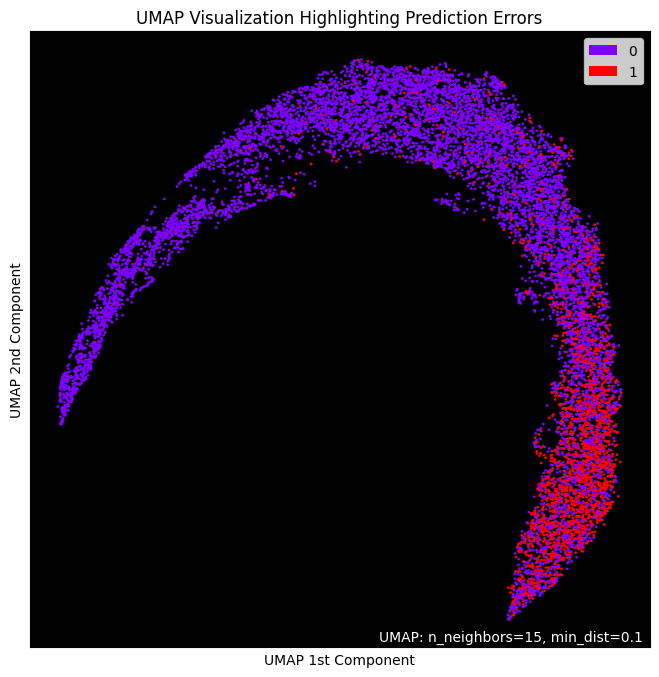

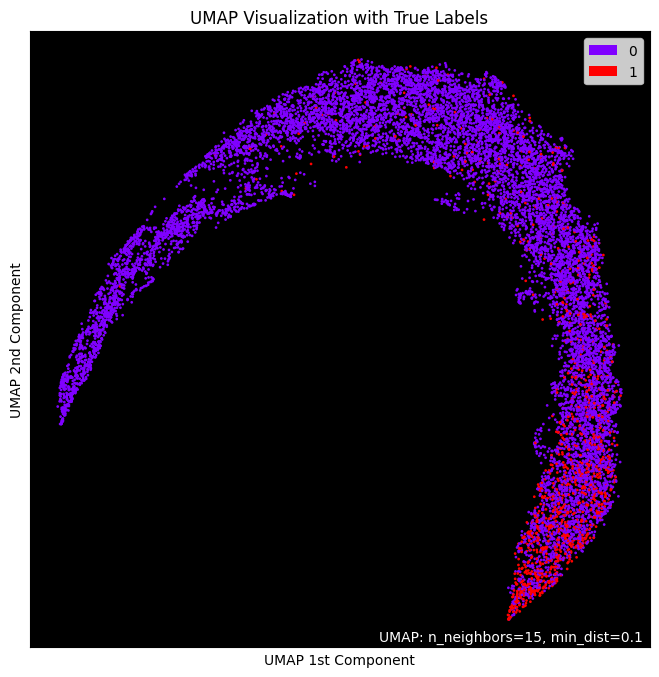

In [70]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

# # Scatter Plot for 2D UMAP Visualization
# x_coords = embedding[:, 0]
# y_coords = embedding[:, 1]
# plt.scatter(x_coords, y_coords, c=labels, cmap='jet', s=15, alpha=0.6, edgecolors='w')
# plt.xlabel('UMAP 1st component')
# plt.ylabel('UMAP 2nd component')
# plt.colorbar(label='Label')
# plt.title('2D UMAP Visualization with Labels')
# plt.show()

#### SHAP Analysis

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


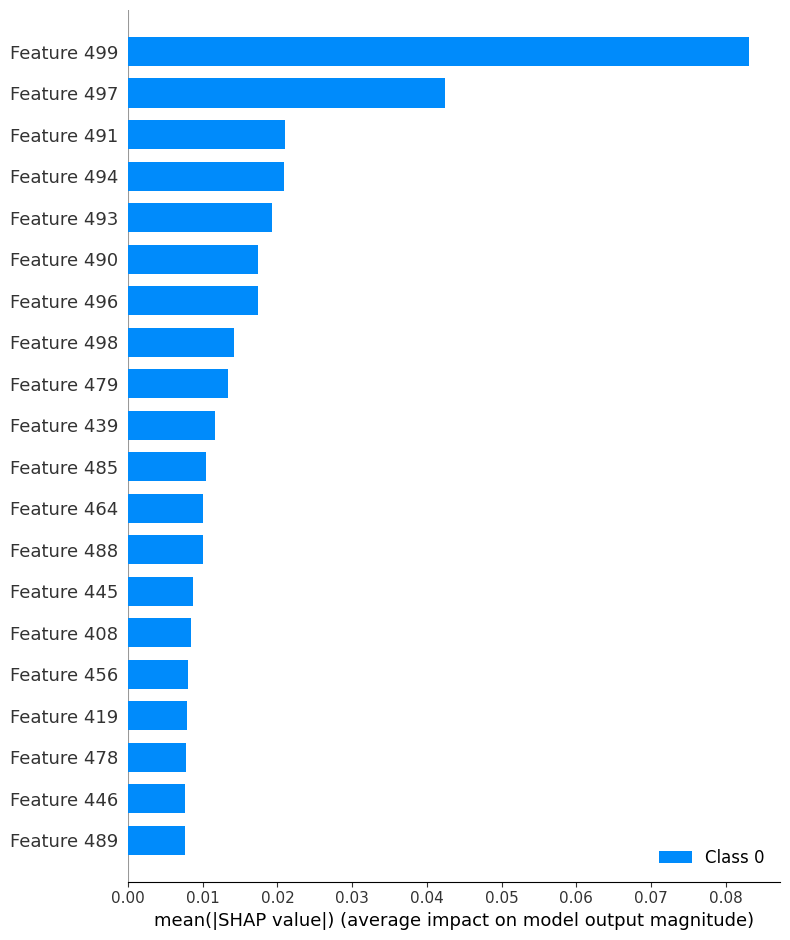

In [78]:
# SHAP analysis
import shap

# Convert pandas DataFrame to numpy array if needed
X_train_scaled_new_array = np.array(X_train_scaled_new)
X_test_scaled_new_array = np.array(X_test_scaled_new)

# Use a smaller random sample for background
background_sample = X_train_scaled_new_array[np.random.choice(X_train_scaled_new_array.shape[0], 1000, replace=False)]

# Initialize the explainer object
explainer = shap.DeepExplainer(model, background_sample)

# Compute the SHAP values
shap_values = explainer.shap_values(X_test_scaled_new_array)

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled_new_array)



## Deep Neural Network (DNN)

In [25]:
# Adjust class weight
# class_weight_0 = len(y_train) / (2 * np.sum(y_train == 0))
# class_weight_1 = len(y_train) / (2 * np.sum(y_train == 1))
# class_weights = {0: class_weight_0, 1: class_weight_1}

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5535 - accuracy: 0.6628 - val_loss: 0.4844 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4458 - accuracy: 0.7674 - val_loss: 0.4458 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4087 - accuracy: 0.7861 - val_loss: 0.4196 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3844 - accuracy: 0.7981 - val_loss: 0.4091 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3679 - accuracy: 0.8032 - val_loss: 0.4327 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3461 - accuracy: 0.8144 - val_loss: 0.3979 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                32064     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

Plot Learning Curves

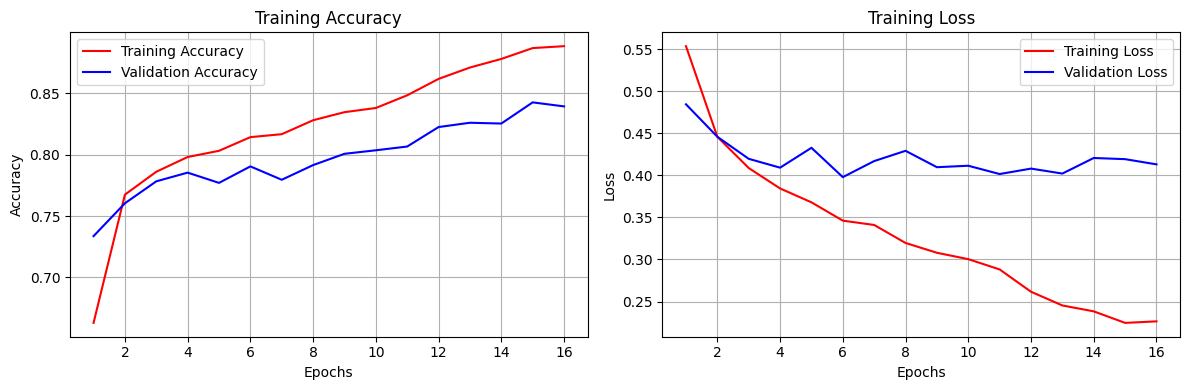

In [27]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [28]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [29]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     10565
           1       0.32      0.80      0.45      1231

    accuracy                           0.80     11796
   macro avg       0.64      0.80      0.67     11796
weighted avg       0.90      0.80      0.83     11796



In [30]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

79.88% - Balanced accuracy Test
88.28% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

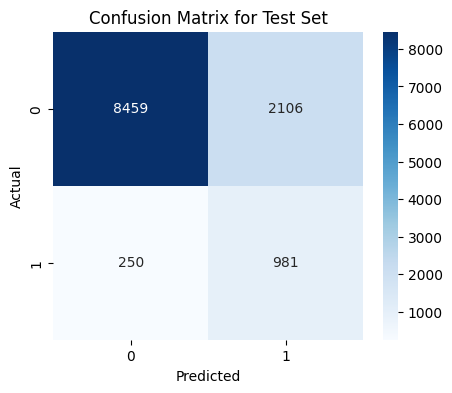

In [31]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

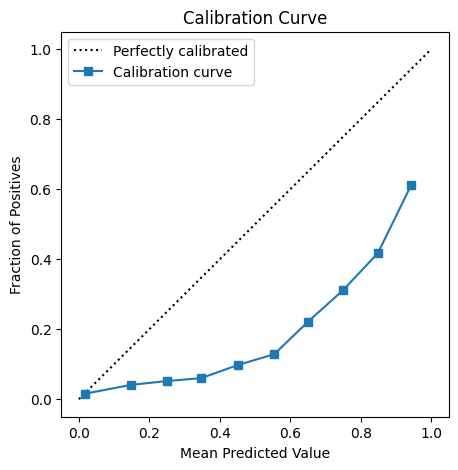

In [32]:
# calibration curve

prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated"). This would mean that for items where the model predicts, say, a 70% chance, 70% of those items actually belong to the positive class.

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [58]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10565
           1       0.65      0.07      0.13      1231

    accuracy                           0.90     11796
   macro avg       0.78      0.53      0.54     11796
weighted avg       0.88      0.90      0.86     11796



In [56]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

53.46% - Balanced accuracy Test
100.00% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

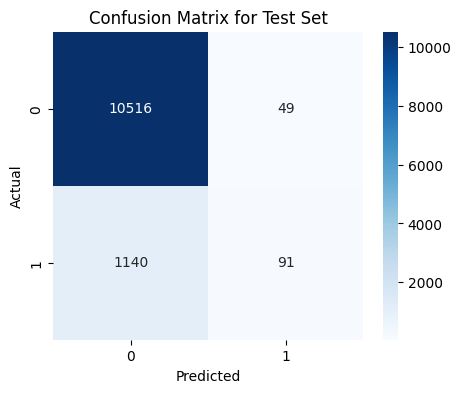

In [36]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

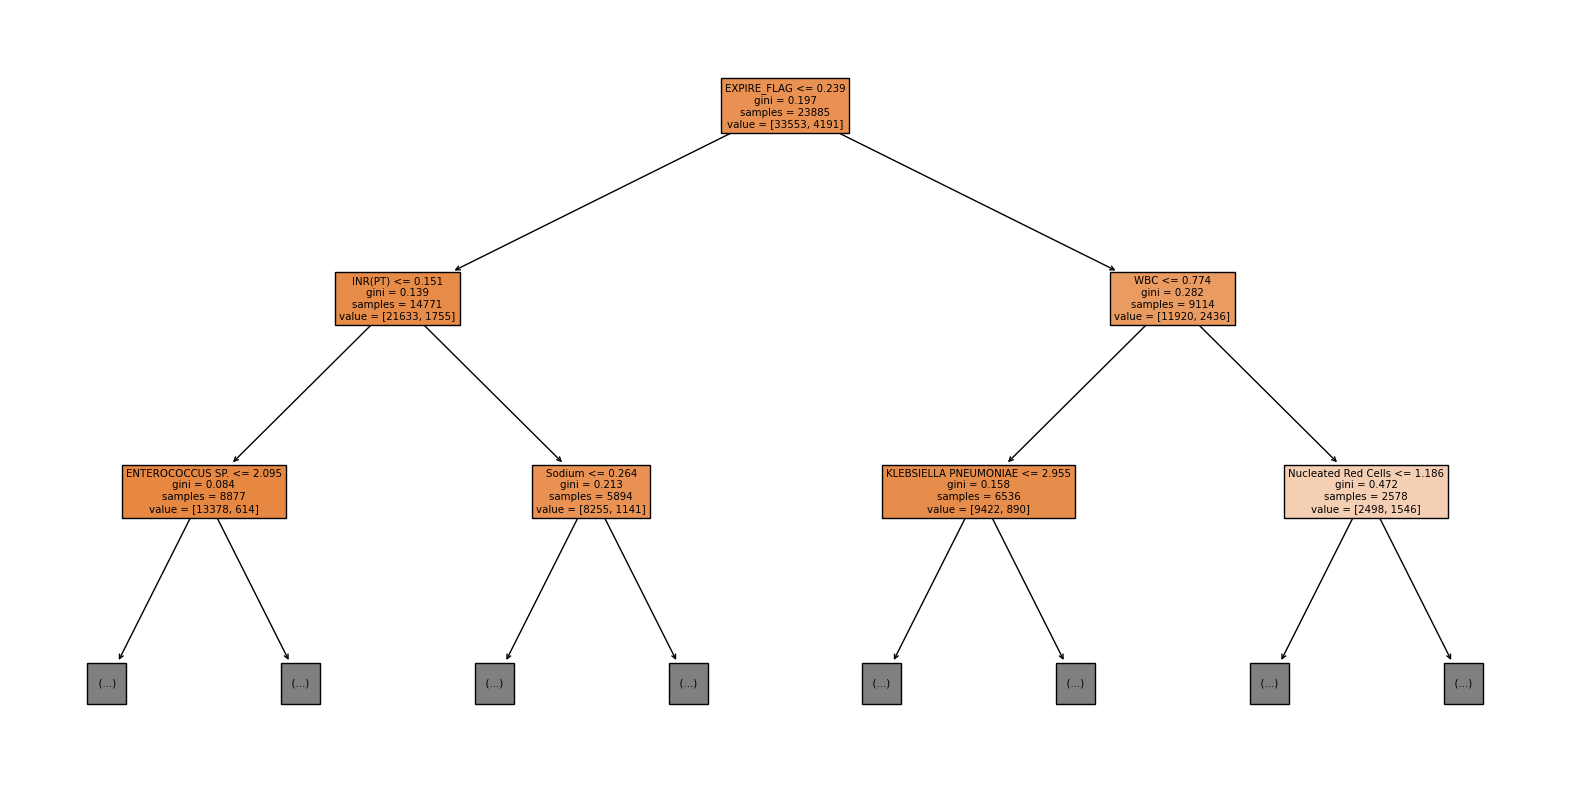

In [37]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

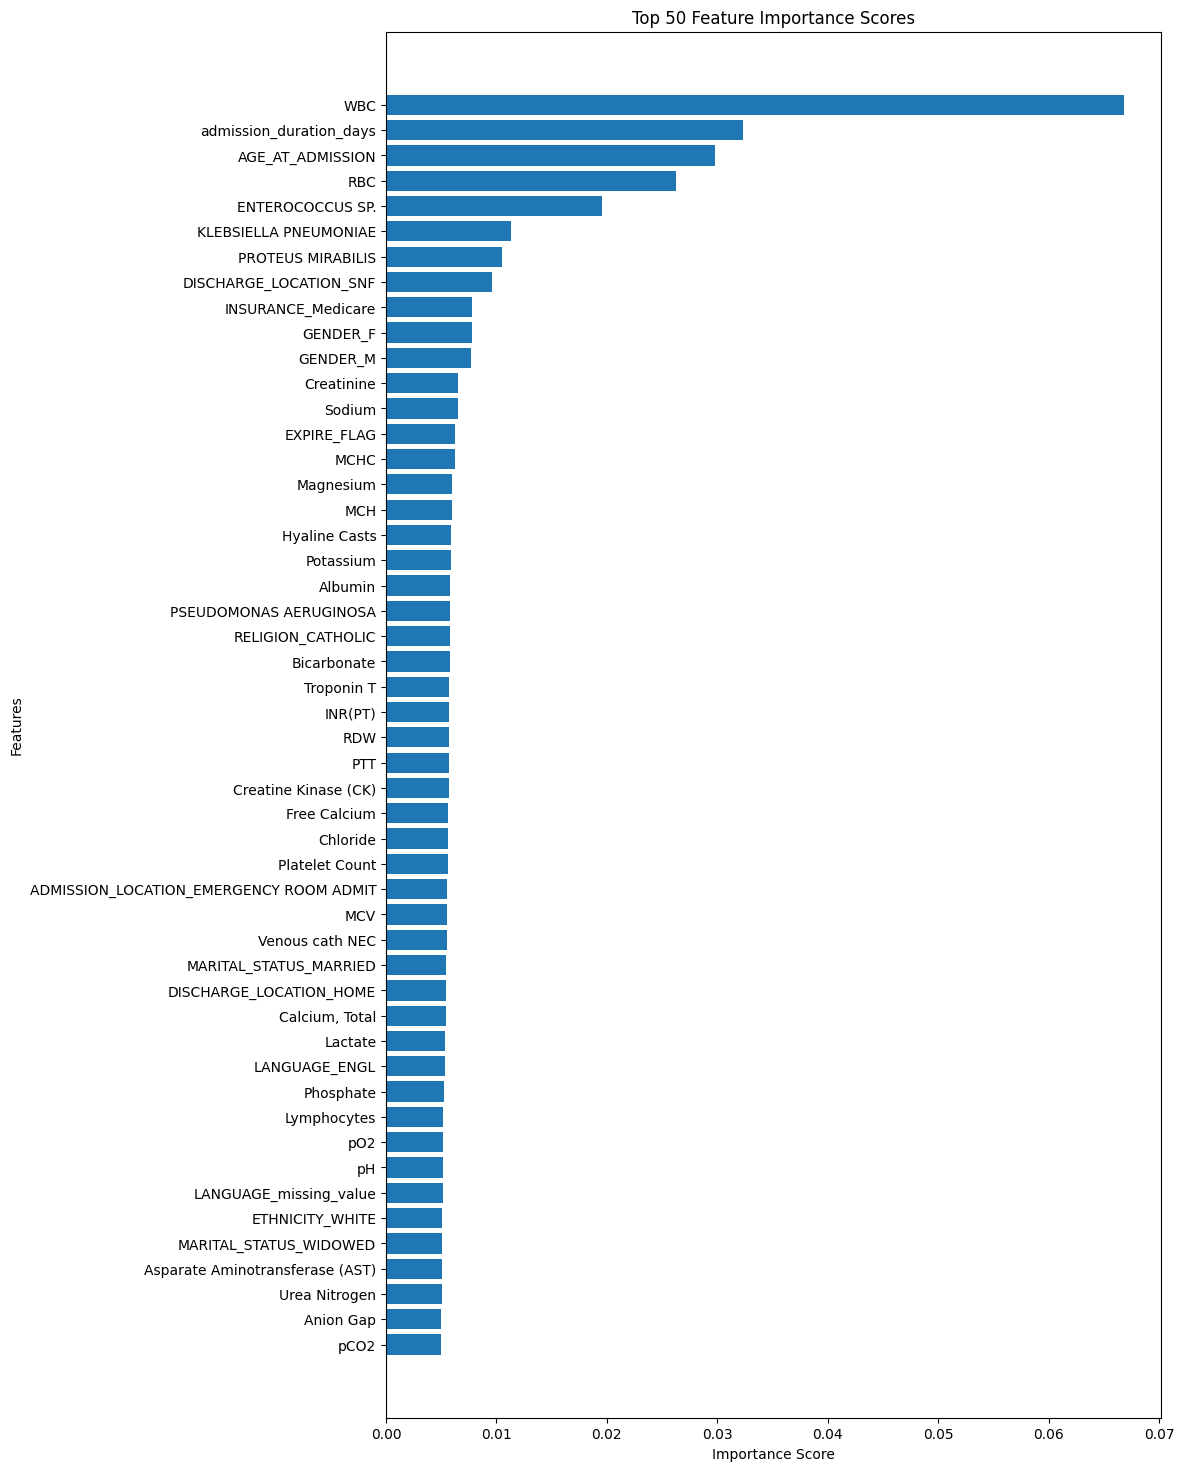

In [38]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [39]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10565
           1       0.57      0.33      0.41      1231

    accuracy                           0.90     11796
   macro avg       0.75      0.65      0.68     11796
weighted avg       0.89      0.90      0.89     11796



In [40]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

64.90% - Balanced accuracy Test
77.48% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

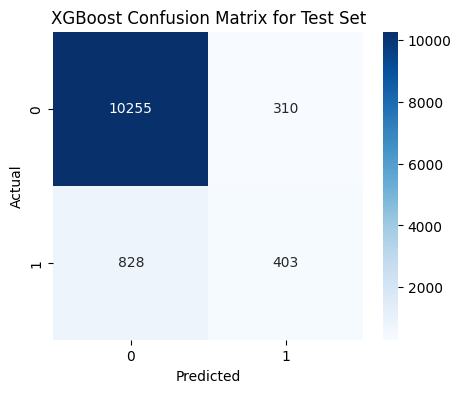

In [41]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('XGBoost Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [42]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 4220, number of negative: 33524
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111806 -> initscore=-2.072426
[LightGBM] [Info] Start training from score -2.072426
LightGBM Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10565
           1       0.60      0.30      0.40      1231

    accuracy                           0.91     11796
   macro avg       0.76      0.64      0.67     11796
weighted avg       0.89      0.91      0.89     11796



In [43]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

63.68% - Balanced accuracy Test
69.89% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

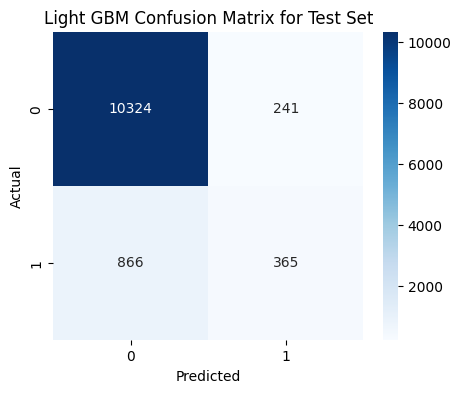

In [44]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Light GBM Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     10565
           1       0.33      0.78      0.47      1231

    accuracy                           0.81     11796
   macro avg       0.65      0.80      0.68     11796
weighted avg       0.90      0.81      0.84     11796



In [64]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

79.94% - Balanced accuracy Test
82.82% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

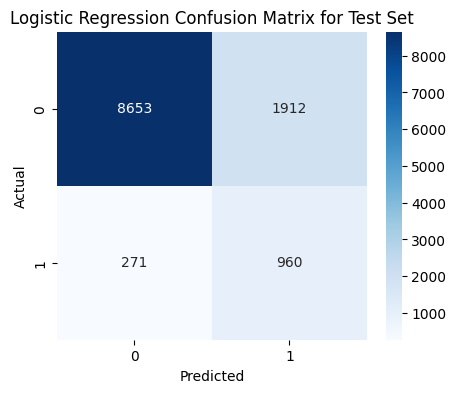

In [49]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, logistic_predictions.round())
train_cm = confusion_matrix(y_train, logistic_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Logistic Regression Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

In [50]:
!pip install shap

In [52]:
import shap

# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values = explainer(X_test_scaled)

# force plot for the first instance
# shap.initjs()
# shap.plots.force(shap_values[0])

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


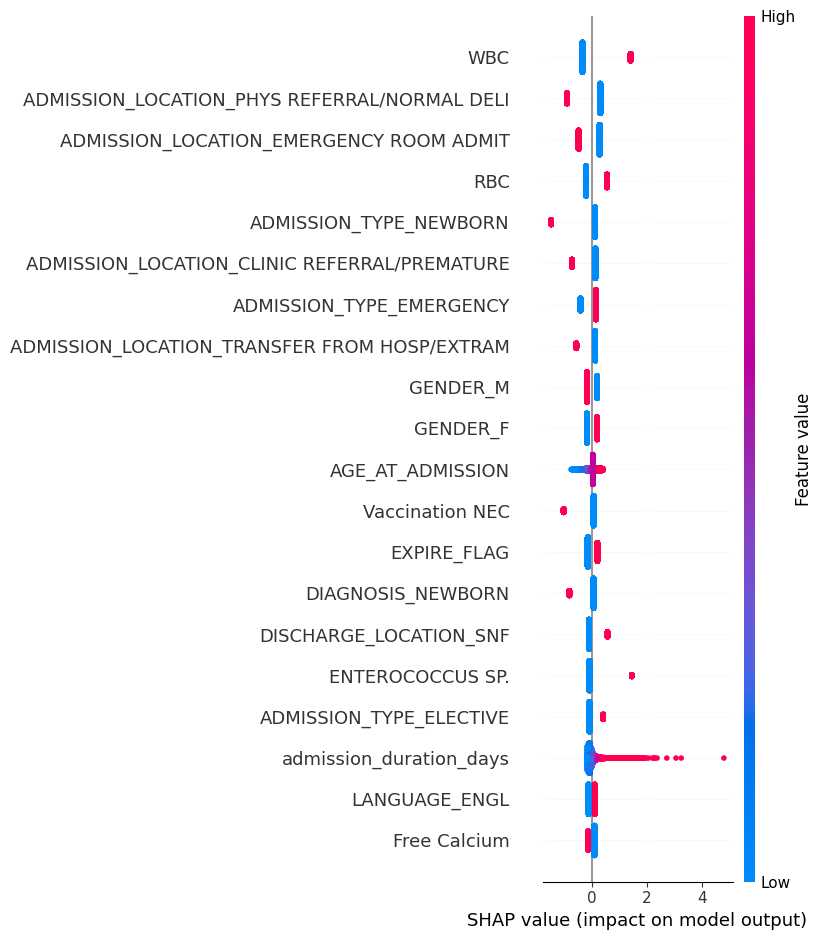

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but LogisticRegression was fitted without feature names


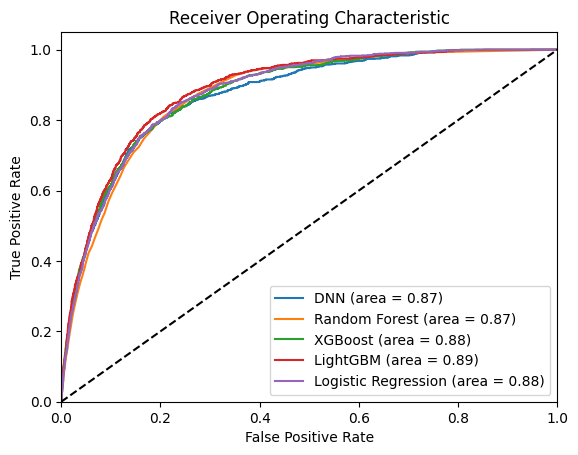

In [60]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
